In [1]:
import sys, os, time
os.chdir("../")
path = os.getcwd()
sys.path.insert(0, path)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.waveform import GenerateEMRIWaveform,Pn5AAKWaveform, AAKWaveformBase
from few.summation.aakwave import AAKSummation
from few.utils.utility import *

import GWGen; from GWGen.WFGenerator import *
from GWGen.Utils import *

# set initial parameters
M = 10000000.0
mu = 1e1
a = .6
e0 = 0.6
p0=GetInitialP(M,e0)
iota0 = 0.
Y0 = np.cos(iota0)
Phi_phi0 = 0.
Phi_theta0 = 0.
Phi_r0 = 0.

qS = 0.2
phiS = 0.2
qK = 0.8
phiK = 0.8
dist = 1.0
mich = False
dt = 15
T = 8

use_gpu = True

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e4),  # all of the trajectories will be well under len = 1000
    "npoints":110,
    "dense_output":False
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

fewtraj = EMRIInspiral(func="pn5")
mytraj = PNTraj()

In [ ]:
# run trajectory
#fewtrajdata = fewtraj(M, mu, a, p0, e0, Y0, T=T,dt=dt,**inspiral_kwargs)
mytrajdata = mytraj(M,mu,a, p0,e0,Y0,T=T,**inspiral_kwargs)

In [ ]:
get_separatrix(a,0.7,1.)

In [ ]:
print(mytraj.exit_reason)
mytrajdata

In [ ]:
cl = Kerr(BHSpin=0.9)
dat = mytrajdata
for inx in range(len(dat[0])):
    try:
        cl.OrbitalFrequencies()(dat[2][inx], dat[1][inx],1.)
    except SystemError as err:
        print(dat[2][inx])
        print(dat[1][inx])
        print(err)

In [ ]:
AAK = AAKWaveformBase(PNTraj, AAKSummation,inspiral_kwargs=inspiral_kwargs.copy(), sum_kwargs=sum_kwargs.copy(),use_gpu=use_gpu)

In [ ]:
dat = tuple((np.require(i, dtype=np.float64, requirements="O") for i in fewtrajdata))
num_modes_kept = nmodes = int(30 * e0)
if num_modes_kept < 4:
    num_modes_kept = nmodes = 4
fewwf = AAK.create_waveform(dat[0], M, a,*dat[1:], mu, qS, phiS, qK, phiK, dist, nmodes,mich=mich,dt=dt,T=T)

In [ ]:
dat = mytrajdata
num_modes_kept = nmodes = int(30 * e0)
if num_modes_kept < 4:
    num_modes_kept = nmodes = 4
mywf = AAK.create_waveform(dat[0], M, a,*dat[1:], mu, qS, phiS, qK, phiK, dist, nmodes,mich=mich,dt=dt,T=T)

In [ ]:
#Plot Trajectories
fig, axes = plt.subplots(4, 2)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(22, 18)
axes = axes.ravel()
ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_\theta$', r'$\Phi_r$', r'$h_{+}$',r'$h_{+}$']
xlabels = [r'$p$', r'$t$',  r'$t$',  r'$t$',               r'$t$',                     r'$t$',            r'$t$',  r'$t$']
datlabel = ["Few Traj",  "My Traj"]
datcolors = ["black", "green", "blue", "yellow", "orange"]
datstyle= ["dashed", "solid", "dashdot", "dotted"]
xdata = [1,0,0,0,0,0]
ydata = [2,1,2,4,5,6]
for i, (ax, xlab, ylab) in enumerate(zip(axes, xlabels, ylabels)):
    if i<len(xdata):
        fx = fewtrajdata[xdata[i]]
        fy = fewtrajdata[ydata[i]]
        mx = mytrajdata[xdata[i]]
        my = mytrajdata[ydata[i]]
        ax.plot(fx,fy, label=datlabel[0],color=datcolors[0], linestyle=datstyle[0])
        ax.plot(mx,my, label=datlabel[1],color=datcolors[1], linestyle=datstyle[1])
    elif i==len(xdata):
        mx = np.arange(len(mywf.get()))*dt
        my = mywf.get().real
        ax.plot(mx,my, label=datlabel[1],color=datcolors[1], linestyle=datstyle[1])
    else:
        fx = np.arange(len(fewwf.get()))*dt
        fy = fewwf.get().real
        ax.plot(fx,fy, label=datlabel[1],color=datcolors[1], linestyle=datstyle[1])


    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)
    ax.legend()
fig.suptitle("My PN5 Trajectory \n e0={0}    p0={1}     a={2}".format(e0,p0,a));

In [ ]:
mytraj.exit_reason

In [ ]:
mytraj.separatrix_cut

In [ ]:
fewtrajdata[1][-1]

In [ ]:
mytrajdata[1][-1]

In [ ]:
    tmparr = np.linspace(1,9,9,dtype=np.int64) #strange floating point error when doing just np.arange(1,10,0.1) for np.linspace(1,10,91). Causes issues when saving numbers to filenames
    tmparr1 = np.linspace(1,9,81, dtype=np.float64)
    SMBHMasses = sorted([int(i) for i in np.kron(tmparr,[1e5, 1e6,1e7])]) #solar masses
    SMBHSpins = [int(100*i)/100 for i in np.linspace(0.6,0.9,10)]
    SecondaryMass = 10 #solar masses
    e0list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
    ProcaMasses = [round(i,22) for i in np.kron(tmparr1, [1e-16,1e-17,1e-18,1e-19])] #eV   #again avoiding floating point errors
    coords=cartesian_product(np.array(SMBHMasses),np.array(SMBHSpins), np.array(ProcaMasses), np.array(e0list))

In [ ]:
from multiprocessing import Pool
def func(arg):
    return alphavalue(arg[0],arg[2])
with Pool(6) as pool:
    alphavals = pool.map(func,coords)

In [ ]:
def func1(it):
    aval = alphavals[it]
    spin = coords[it][1]
    if aval>0.02 and aval<BHSpinAlphaCutoff(spin):
        return True
    else:
        return False

with Pool(6) as p:
    booles = p.map(func1, range(len(coords)))

In [ ]:
len(np.array(alphavals)[booles])/1000/24

In [ ]:
newcoord = []
for arg in coords:
    alphaval = alphavalue(arg[0], arg[2])
    if alphaval>0.02 and alphaval<BHSpinAlphaCutoff(arg[1]):
        newcoord.append(arg)

In [ ]:
len(newcoord)

In [ ]:
import time

from few.utils.constants import *
from GWGen.WFGenerator import *
trajcl = PNTraj()


In [ ]:
## Algorithm to determine initial semi-latus rectum for given values of bhmass, bhspin, and initial eccentricity and desired time length of 5 years

tmparr = np.linspace(1,9,9,dtype=np.int64) #strange floating point error when doing just np.arange(1,10,0.1) for np.linspace(1,10,91). Causes issues when saving numbers to filenames
tmparr1 = np.linspace(1,9,81, dtype=np.float64)
SMBHMasses = sorted([int(i) for i in np.kron(tmparr,[1e5, 1e6,1e7])]) #solar masses
SMBHSpins = [int(100*i)/100 for i in np.linspace(0.6,0.9,10)]
SecondaryMass = 10 #solar masses
e0list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]

def get_status(time, exit_reason):
    if 4.9<time<5.1 and exit_reason=='Separatrix reached!':
        return True
    else:
        return False

finaldata = {}
for bm in SMBHMasses:
    for a in SMBHSpins:
        for e0 in e0list:
            status=False
            traj = trajcl(bm,10,a,6,e0,1.,T=5)
            
            while not status:
                finalp = traj[1][-1];
                initialp = traj[1][0];
                status = get_status(finaltimeyear, trajcl.exit_reason)
                if status:
                    key = "bm"+str(bm)+"a"+str(a)+"e0"+str(e0)
                    finaldata[key] = initialp
                    print(key, "  ", initialp)
                elif not status:
                    print(trajcl.exit_reason)
                    print("final p: ",finalp)
                    if "time boundary" in trajcl.exit_reason:
                        traj = trajcl(bm,10,a,finalp-1,e0,1.,T=5)
                        print("decreasing initial p")
                        print(finalp)
                    elif "Separatrix" in trajcl.exit_reason:
                        traj = trajcl(bm,10,a,traj[1][0]+1,e0,1.,T=5)
                        print("new final p: ", traj[1][0])
                        print("increasing initial p")            

In [ ]:
print(bm)
print(a)
print(e0)

In [ ]:
res=trajcl(1e5,10,0.6,10,0.1,1.,T=1)

In [ ]:
trajcl.exit_reason

In [4]:
import numpy as np
import itertools

def split(a, n):
            k, m = divmod(len(a), n)
            return list(a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)
a = np.arange(1,11)
n=3
splita = split(a,n)
trana = np.transpose(splita)
itera = list(itertools.zip_longest(*splita))
print(a)
print(splita)
print(itera)

[ 1  2  3  4  5  6  7  8  9 10]
[array([1, 2, 3, 4]), array([5, 6, 7]), array([ 8,  9, 10])]
[(1, 5, 8), (2, 6, 9), (3, 7, 10), (4, None, None)]


In [67]:
    tmparr = np.linspace(1,9,9,dtype=np.int64) #strange floating point error when doing just np.arange(1,10,0.1) for np.linspace(1,10,91). Causes issues when saving numbers to filenames
    tmparr1 = np.linspace(1,9,81, dtype=np.float64)
    SMBHMasses = sorted([int(i) for i in np.kron(tmparr,[1e5, 1e6,1e7])]) #solar masses
    SMBHSpins = [int(100*i)/100 for i in np.linspace(0.6,0.9,10)]
    SecondaryMass = 10 #solar masses
    e0list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
    ProcaMasses = sorted([round(i,22) for i in np.kron(tmparr1, [1e-16,1e-17,1e-18,1e-19])]) #eV   #again avoiding floating point errors
    n=17
    commsize = 2000

    parallel_args = cartesian_product(np.array(SMBHMasses),np.array(SMBHSpins), np.array(ProcaMasses), np.array(e0list))
    def parallel_func(args,solcount,sols):
        if args!=None:
            process(args[0], args[1], args[2], args[3], SecondaryMass=SecondaryMass, DataDir=DataDir, alphauppercutoff=BHSpinAlphaCutoff(args[1]),mpirank=rank, solcounter=solcount,nsols=nsols,OverwriteSolution=overwriteexisting, plot=PlotData)
        return None
    #parallel_func = lambda args,solcount,nsols: process(args[0], args[1], args[2], args[3], SecondaryMass=SecondaryMass, DataDir=DataDir, alphauppercutoff=BHSpinAlphaCutoff(args[1]),mpirank=rank, solcounter=solcount,nsols=nsols,OverwriteSolution=overwriteexisting, plot=PlotData)

    def split(a, n):
        k, m = divmod(len(a), n)
        return list(a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
    if divmod(len(parallel_args),commsize)[1]!=0:
        nsplit = len(parallel_args)//commsize+1
    else:
        nsplit=len(parallel_args)//commsize
    split_parallel_args = split(parallel_args, nsplit)
    split_parallel_args = list(itertools.zip_longest(*split_parallel_args))
    [split_parallel_args.append([None]) for i in range(commsize-len(split_parallel_args))]

    print(divmod(len(parallel_args),commsize))
    print(np.shape(split_parallel_args))

(306, 360)
(2000,)


In [29]:
[split_parallel_args.append([None]) for i in range(commsize-len(split_parallel_args))]

[None, None, None, None, None]

In [30]:
split_parallel_args[-5]

[None]

In [149]:
pn.UndressedeFlux(ecc,semimaj)

-6.916804313071245e-10

In [33]:
ulb = superrad.ultralight_boson.UltralightBoson(spin=1,model="relativistic")
pn = PN(6e7,10,bhspin=0.8)

In [73]:
ratelist = {"asymptotic dEdt":[], "asymptotic dLdt":[], "asymptotic dpdt":[], "asymptotic dedt":[], "fracE":[], "fracL":[], "fracEnDen":[], "Boson Cloud Full GWEFlux":[]}
#procamasses = np.linspace(3.1e-19,5.7e-19,39)
procamasses = np.linspace(1.7e-16, 2.2e-16,40)
ecc=0.1
semimaj=4.8
bhspin = 0.6
M = 1e5
dldp = pn.dLdp()(ecc,semimaj)*pn.dLdpUnit
dlde = pn.dLde()(ecc,semimaj)*pn.dLdeUnit
dedp = pn.dEdp()(ecc,semimaj)*pn.dEdpUnit
dede = pn.dEde()(ecc,semimaj)*pn.dEdeUnit
norm = (dldp*dede - dlde*dedp)
for mu in procamasses:
    pc = ProcaSolution(M,bhspin,mu,UltralightBoson=ulb)
    t=0
    e=0.1
    p=4.8
    rates = pc.ChangeInOrbitalConstants(SecondaryMass=10,SMBHMass=6e7)
    pcoor = (1/norm)*(dede*rates["L"](t,e,p) - dlde*rates["E"](t,e,p))
    ecoor = (1/norm)*(dldp*rates["E"](t,e,p) - dedp*rates["L"](t,e,p))
    ratelist["asymptotic dEdt"].append(rates["E"](t,e,p))
    ratelist["asymptotic dLdt"].append(rates["L"](t,e,p))
    ratelist["asymptotic dpdt"].append(pcoor)
    ratelist["asymptotic dedt"].append(ecoor)
    ratelist["fracE"].append(pc.FractionalGWEFlux()(t,p))
    ratelist["fracL"].append(pc.FractionalGWLFlux()(t,p))
    ratelist["fracEnDen"].append(pc.FractionalEnergyDensity(p)**2)
    ratelist["Boson Cloud Full GWEFlux"].append(pc.BosonCloudGWEFlux(t))

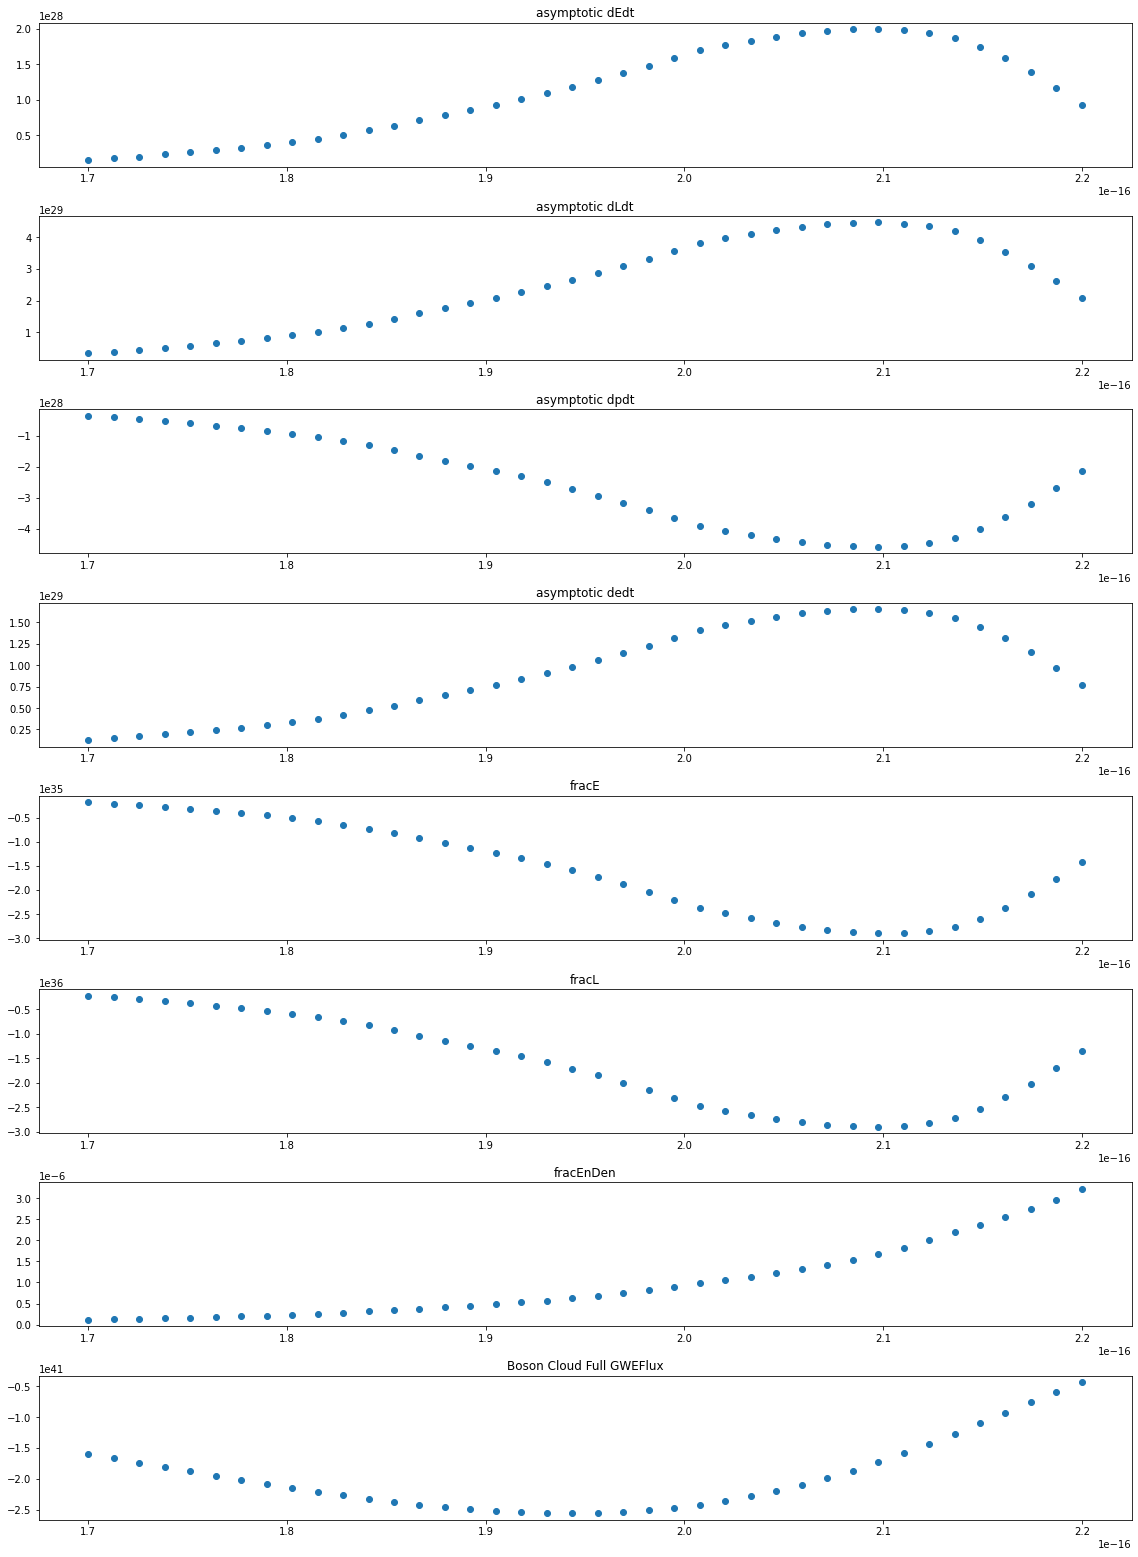

In [74]:
fig,ax = plt.subplots(len(ratelist.keys()), figsize=(16,14))
fig.tight_layout()
plt.subplots_adjust(bottom=-.5)
for inx, key in enumerate(ratelist.keys()):
    ax[inx].scatter(procamasses, ratelist[key])
    ax[inx].set_title(key)

In [10]:
insp_kwargs = {
    "npoints": 110,  # we want a densely sampled trajectory
    "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "dense_output":True
}
# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": False,  # GPU is availabel for this type of summation
    "pad_output": False,
}
# set initial parameters
M = 6e7
m = 1e1
mu = 5.4e-19
e0 = 0.1
p0 = GetInitialP(M,e0)
Phi_phi0 = 0.
Phi_theta0 =0.
Phi_r0 = 0.
a=0.8 #SMBH Spin
Y0=1. #Initial Inclincation
qS=np.pi/4 #Sky Location Polar Angle in solar system barycenter coordinate system
phiS=0. #Sky Location Azimuthal Angle in solar system barycenter coordinate system
qK=1e-6 #Initial BH Spin Polar Angle in solar system barycenter coordinate system
phiK=0. #Initial BH Spin Azimuthal Angle in solar system barycenter coordinate system
dist=1. #Distance to source (Mpc)
mich=False #assume LISA long baseline response approximation
T=5.8 #LISA data run is 5 years. We set the max time to be longer because the proca cloud extends the inspiral time
dt=15 #time resolution in seconds
ProcaInspiralKwargs = insp_kwargs.copy()
ProcaSumKwargs = sum_kwargs.copy()
withprocagen = EMRIWithProcaWaveform(inspiral_kwargs=ProcaInspiralKwargs,sum_kwargs=ProcaSumKwargs)
WithoutProcaInspiralKwargs = insp_kwargs.copy()
WithoutProcaSumKwargs=sum_kwargs.copy()
withoutprocagen = EMRIWaveform(inspiral_kwargs=WithoutProcaInspiralKwargs, sum_kwargs=WithoutProcaSumKwargs, use_gpu=False)
import superrad
ulb = superrad.ultralight_boson.UltralightBoson(spin=1,model="relativistic")

In [ ]:
#iterate through mass and look at resulting trajectory. Why does trajectory become more alike around proca masses o 5.4e-19 for a=0.8, e0=0.1, M=6e7?

In [13]:
withoutproca = withoutprocagen(M, m, a, p0, e0, Y0, qS, phiS, qK, phiK, dist,Phi_phi0=Phi_phi0, Phi_theta0=Phi_theta0, Phi_r0=Phi_r0, mich=mich, dt=dt, T=T)
withoutptraj = withoutprocagen.Trajectory
combinetraj = {}
for pmass in np.linspace(5e-19,5.5e-19, 6):
    withproca = withprocagen(M,m,pmass,a,p0,e0,Y0,T=T,qS=qS,phiS=phiS,qK=qK,phiK=phiK,dist=dist,mich=mich, UltralightBoson=ulb)
    withptraj = withprocagen.Trajectory
    combinetraj[str(pmass*1e19)] = {"without":withoutptraj, "with":withptraj}
    

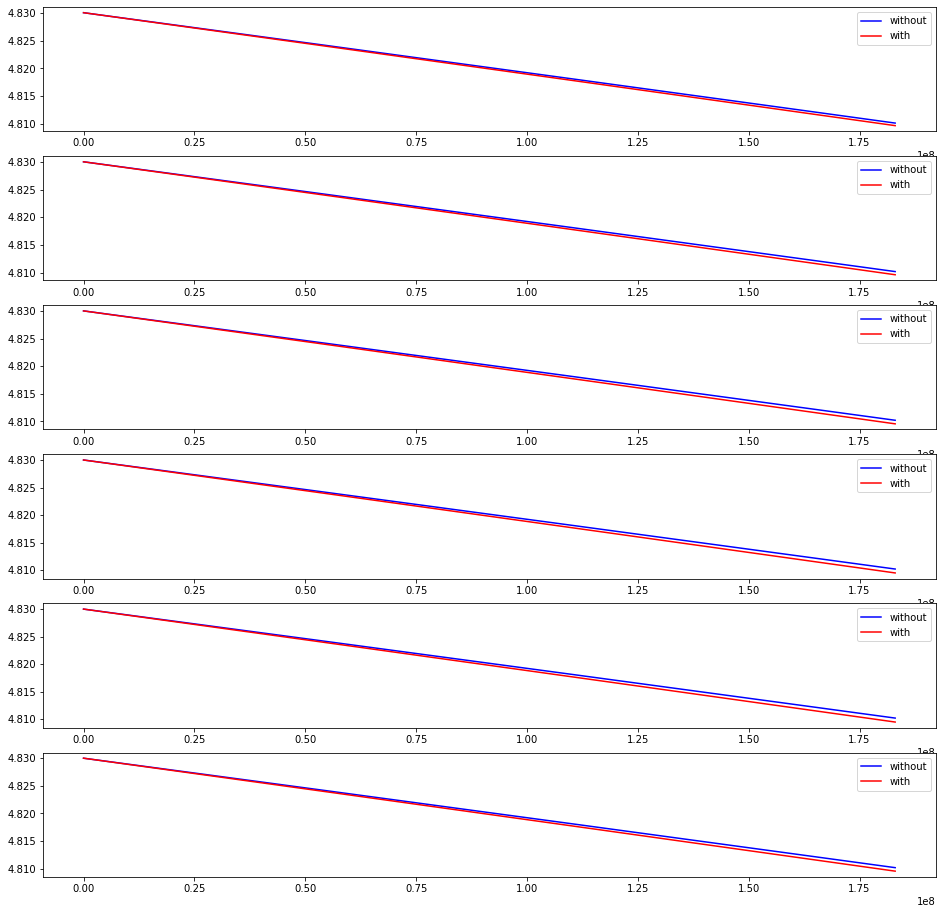

In [31]:
fig, ax = plt.subplots(len(combinetraj.keys()), figsize=(16,16))
for inx, key in enumerate(combinetraj.keys()):
    wo_x = combinetraj[key]["without"]["t"]
    w_x = combinetraj[key]["with"]["t"]
    wo_y = combinetraj[key]["without"]["p"]
    w_y = combinetraj[key]["with"]["p"]
    ax[inx].plot(wo_x, wo_y, label="without", color="blue")
    ax[inx].plot(w_x, w_y, label="with", color="red")
    ax[inx].legend()